In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mcts import mcts
from mcts import firstActionPolicy
from mcts import randomPolicy
from simulator import farmcell
from bruteforce import bruteforce

import numpy as np
import matplotlib.pyplot as plt
import timeit
import math

In [9]:
class options:
    def __init__(self, agent_persists = False, explorationConstant = 1 / math.sqrt(2), timeLimit = 1000, iterationLimit = 0):
        self.agent_persists = agent_persists
        self.explorationConstant = explorationConstant
        self.timeLimit = timeLimit
        self.iterationLimit = iterationLimit
        
class Runner:
    def __init__(self, farm_size, options):
        self.n = farm_size
        self.options = options
        self.rewards = []
        self.full_tree_over_time = []        
        self.best_farm = None
        self.best_reward = 0
        self.first_best_epoch_index = 0

        farm = np.zeros((self.n, self.n), dtype=int)
        self.initialState = farmcell((0, 0), farm)

        constInitState = self.initialState if self.options.agent_persists else None
        if (self.options.iterationLimit > 0):
            self.agent = mcts(iterationLimit=self.options.iterationLimit,
                              rolloutPolicy=randomPolicy,
                              explorationConstant=self.options.explorationConstant,
                              initialState=constInitState)
        else:
            self.agent = mcts(timeLimit=self.options.timeLimit,
                              rolloutPolicy=randomPolicy,
                              explorationConstant=self.options.explorationConstant,
                              initialState=constInitState)
        
    def run(self, epochs):        
        for i in range(epochs):
            _ = self.agent.search(initialState=None if self.options.agent_persists else self.initialState)

            last_state, full_tree = self.agent.optimal_rollout()
            self.full_tree_over_time.append(1 if full_tree else 0)
            reward = last_state.state.getReward()
            self.rewards.append(reward)
            
            if reward > self.best_reward:
                self.best_reward = reward
                self.best_farm = last_state.state.farm
                self.first_best_epoch_index = i
                
    def plot(self):
        print ('Best reward: {}'.format(self.best_reward))
        print ('Epoch where best reward occured first time: {}'.format(self.first_best_epoch_index))
        print ('Best farm:')
        print (self.best_farm)
        plt.subplot(2, 1, 1)
        plt.title('Reward with epochs')
        plt.plot(self.rewards)
        plt.ylabel('Reward')
        plt.subplot(2, 1, 2)
        plt.plot(self.full_tree_over_time)
        plt.ylabel('Fully built tree?')
        plt.show()
        
    def run_and_plot(self, epochs):
        self.run(epochs)
        self.plot()


Best reward: 138
Epoch where best reward occured first time: 2
Best farm:
[[1 1 1]
 [1 2 1]
 [1 1 1]]


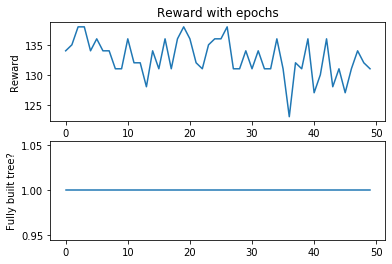

In [10]:
r = Runner(farm_size=3, options=options())
r.run_and_plot(epochs = 50)

Best reward: 134
Epoch where best reward occured first time: 0
Best farm:
[[1 1 2]
 [1 2 1]
 [1 1 1]]


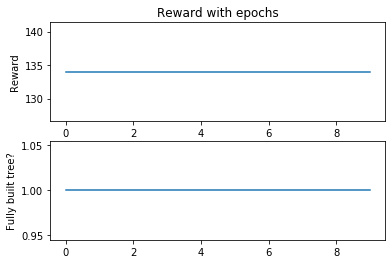

In [13]:
# Question: Is it good to persist the tree across searches?
# Answer: No (confidence : high for this problem and most likely in general)
r = Runner(farm_size=3, options=options(agent_persists=True))
r.run_and_plot(epochs = 10)

Best reward: 242
Epoch where best reward occured first time: 24
Best farm:
[[1 1 2 1]
 [2 1 1 1]
 [1 2 2 1]
 [1 1 1 1]]


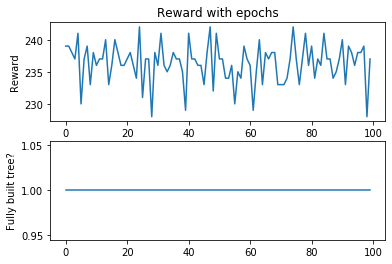

In [12]:
r = Runner(farm_size=4, options=options())
r.run_and_plot(epochs = 100)

Best reward: 242
Epoch where best reward occured first time: 7
Best farm:
[[1 1 1 1]
 [1 2 1 2]
 [1 2 1 1]
 [1 1 1 2]]


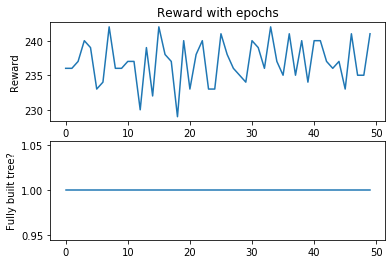

In [14]:
# Question: What effect does increasing the time limit have?
# Answer : Good (confidence: medium, need to do more runs, 
#          theortically above should encourage exploration more and have better estimates, so the result should be better)
r = Runner(farm_size=4, options=options(timeLimit=5000))
r.run_and_plot(epochs = 50)

Best reward: 242
Epoch where best reward occured first time: 16
Best farm:
[[1 2 1 1]
 [1 1 2 1]
 [2 1 2 1]
 [1 1 1 1]]


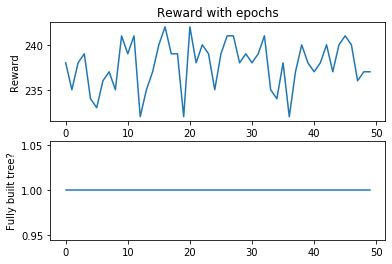

In [15]:
# Question: What effect does changing the exploration constant have? 
# (Need to read the paper more thouroughly to even decide what's the best way to do this)
# Answer : ?
r = Runner(farm_size=4, options=options(explorationConstant=1))
r.run_and_plot(epochs = 50)

Best reward: 1505
Epoch where best reward occured first time: 46
Best farm:
[[1 1 1 2 1 1 1 1 2 1]
 [2 1 1 1 1 1 2 1 2 1]
 [1 1 1 1 2 1 1 2 1 1]
 [1 2 1 1 2 1 1 2 2 1]
 [1 1 2 1 2 1 1 2 1 2]
 [1 2 1 1 2 1 2 1 1 1]
 [1 2 1 1 2 2 1 1 1 2]
 [1 1 1 1 1 2 1 1 2 1]
 [2 1 2 2 1 1 2 2 1 1]
 [1 1 1 1 1 1 2 1 2 2]]


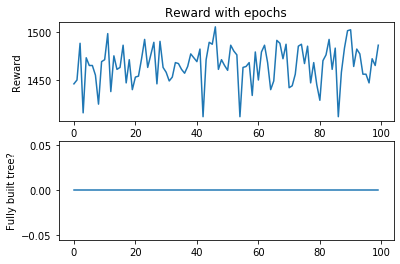

In [16]:
r = Runner(farm_size = 10, options=options())
r.run_and_plot(epochs = 100)

In [13]:
# Try the brute force way (for small n) to compare against
def find_optimal_by_brute_force(farm_size):
    b = bruteforce(farm_size)
    start = timeit.default_timer()
    best_reward, best_farm, total_inputs = b.solve()
    end = timeit.default_timer()

    print ('best farm:')
    print (best_farm)
    print ('best_reward: {}'.format(best_reward))
    print ('total number of configurations need to be tested: {}'.format(total_inputs))
    print ('total time taken: {}'.format(end-start))

In [14]:
find_optimal_by_brute_force(3)

best farm:
[[1 1 1]
 [1 2 1]
 [1 1 1]]
best_reward: 138
total number of configurations need to be tested: 512
total time taken: 0.14634298599992235


In [15]:
find_optimal_by_brute_force(4)

best farm:
[[1 1 1 1]
 [1 2 1 2]
 [1 2 1 1]
 [1 1 1 2]]
best_reward: 242
total number of configurations need to be tested: 65536
total time taken: 31.47645004399999


In [ ]:
# find_optimal_by_brute_force(5) # This is expected to take more than 4 hours to run!!!